# Phân Tích Dữ Liệu Khách Hàng QVI

Notebook này thực hiện phân tích chi tiết dữ liệu giao dịch và hành vi mua hàng của khách hàng QVI.

## 1. Thiết Lập Ban Đầu và Tải Thư Viện

Trước tiên, chúng ta cần tải các thư viện cần thiết và thiết lập một số cấu hình mặc định cho biểu đồ.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re # Added import for regular expressions

# Set style for plots
# Changed 'seaborn' to a current style like 'seaborn-v0_8-whitegrid'
plt.style.use('seaborn-v0_8-whitegrid') 
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = [12, 6]

## 2. Định Nghĩa Các Hàm Xử Lý

### 2.1. Tải Dữ Liệu

In [2]:
def load_data():
    """Load the datasets"""
    print("Loading data...")
    # Ensure these files are in the same directory as your script,
    # or provide the full path to them.
    try:
        transaction_data = pd.read_excel('QVI_transaction_data.xlsx')
        purchase_behavior = pd.read_csv('QVI_purchase_behaviour.csv')
        print("Data loaded successfully.")
        return transaction_data, purchase_behavior
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure 'QVI_transaction_data.xlsx' and 'QVI_purchase_behaviour.csv' are in the correct directory.")
        return None, None

### 2.2. Kiểm Tra Dữ Liệu Ban Đầu

In [3]:
def examine_data(transaction_data, purchase_behavior):
    """Examine the structure of the data"""
    if transaction_data is None or purchase_behavior is None:
        print("Cannot examine data as it was not loaded.")
        return

    print("\nTransaction Data Info:")
    transaction_data.info()
    print("\nSample of transaction data:")
    print(transaction_data.head())
    
    print("\nPurchase Behavior Info:")
    purchase_behavior.info()
    print("\nSample of purchase behavior data:")
    print(purchase_behavior.head())

### 2.3. Làm Sạch Dữ Liệu Giao Dịch

In [4]:
def clean_transaction_data(df):
    """Clean and preprocess transaction data"""
    if df is None:
        print("Transaction data is None, skipping cleaning.")
        return None
    print("\nCleaning transaction data...")
    
    # Convert DATE to datetime
    # It's good practice to handle potential errors during conversion
    try:
        df['DATE'] = pd.to_datetime(df['DATE'], origin='1899-12-30', unit='D')
    except Exception as e:
        print(f"Error converting DATE column to datetime: {e}")
        return df 
    
    print("\nExamining product names:")
    print(df['PROD_NAME'].value_counts().head())
    
    if not df['PROD_NAME'].empty and df['PROD_NAME'].dtype == 'object':
        try:
            words = pd.Series(' '.join(df['PROD_NAME'].dropna()).split()).value_counts()
            words = words[~words.index.str.contains('\\d', na=False)] 
            words = words[words.index.str.match('^[a-zA-Z]+$', na=False)] 
            print("\nMost common words in product names (alphabetic only):")
            print(words.head(10))
        except Exception as e:
            print(f"Error analyzing words in product names: {e}")
    else:
        print("PROD_NAME column is empty or not of string type, skipping word analysis.")

    df = df[~df['PROD_NAME'].str.contains('salsa', case=False, na=False)]
    
    print("\nChecking for outliers in product quantity:")
    print(df['PROD_QTY'].describe())
    
    high_qty = df[df['PROD_QTY'] == 200]
    print("\nTransactions with quantity = 200:")
    print(high_qty)
    
    if 'LYLTY_CARD_NBR' in df.columns:
        df = df[df['LYLTY_CARD_NBR'] != 226000]
    else:
        print("LYLTY_CARD_NBR column not found, skipping outlier customer removal.")
        
    print("Transaction data cleaning complete.")
    return df

### 2.4. Phân Tích Ngày Giao Dịch

In [5]:
def analyze_dates(df):
    """Analyze transaction dates"""
    if df is None or 'DATE' not in df.columns:
        print("Data or DATE column is missing, skipping date analysis.")
        return
    print("\nAnalyzing transaction dates...")
    
    daily_transactions = df.groupby('DATE').size()
    
    if daily_transactions.empty:
        print("No transactions found to analyze by date.")
        return

    plt.figure()
    daily_transactions.plot()
    plt.title('Transactions over time')
    plt.xlabel('Date')
    plt.ylabel('Number of transactions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    december_transactions = daily_transactions[daily_transactions.index.month == 12]
    if not december_transactions.empty:
        plt.figure()
        december_transactions.plot()
        plt.title('December Transactions')
        plt.xlabel('Date')
        plt.ylabel('Number of transactions')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No transactions found in December.")
    print("Date analysis complete.")

### 2.5. Phân Tích Kích Thước Gói Sản Phẩm

In [6]:
def analyze_pack_sizes(df):
    """Analyze pack sizes"""
    if df is None or 'PROD_NAME' not in df.columns:
        print("Data or PROD_NAME column is missing, skipping pack size analysis.")
        return df
    print("\nAnalyzing pack sizes...")
    
    def extract_pack_size(name):
        if pd.isna(name):
            return None
        match = re.search(r'(\d+)g', str(name)) 
        if match:
            return int(match.group(1))
        return None

    df['PACK_SIZE'] = df['PROD_NAME'].apply(extract_pack_size)
    
    if 'PACK_SIZE' in df.columns and not df['PACK_SIZE'].dropna().empty:
        pack_size_dist = df['PACK_SIZE'].value_counts().sort_index()
        print("\nPack size distribution:")
        print(pack_size_dist)
        
        plt.figure()
        plt.hist(df['PACK_SIZE'].dropna(), bins=30) 
        plt.title('Distribution of Pack Sizes')
        plt.xlabel('Pack Size (g)')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No pack sizes found or PACK_SIZE column is empty.")
    print("Pack size analysis complete.")
    return df

### 2.6. Phân Tích Thương Hiệu

In [7]:
def analyze_brands(df):
    """Analyze brands"""
    if df is None or 'PROD_NAME' not in df.columns:
        print("Data or PROD_NAME column is missing, skipping brand analysis.")
        return df
    print("\nAnalyzing brands...")
    
    df['BRAND'] = df['PROD_NAME'].apply(lambda x: str(x).split()[0].upper() if pd.notna(x) and str(x).split() else None)
    
    brand_mapping = {
        'RRD': 'RED_ROCK_DELI',
        'SNBTS': 'SUNBITES',
        'INFZNS': 'INFUZIONS',
        'WW': 'WOOLWORTHS',
        'SMITH': 'SMITHS',
        'NCC': 'NATURAL',
        'DORITO': 'DORITOS',
        'GRAIN': 'GRAINWAVES'
    }
    df['BRAND'] = df['BRAND'].replace(brand_mapping)
    
    if 'BRAND' in df.columns and not df['BRAND'].dropna().empty:
        print("\nBrand distribution:")
        print(df['BRAND'].value_counts())
    else:
        print("No brands found or BRAND column is empty.")
    print("Brand analysis complete.")
    return df

### 2.7. Phân Tích Phân Khúc Khách Hàng

In [8]:
def analyze_customer_segments(data):
    """Analyze customer segments"""
    if data is None or not all(col in data.columns for col in ['TOT_SALES', 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'LYLTY_CARD_NBR']):
        print("Data or required columns (TOT_SALES, PREMIUM_CUSTOMER, LIFESTAGE, LYLTY_CARD_NBR) are missing, skipping customer segment analysis.")
        return
    print("\nAnalyzing customer segments...")
    
    try:
        sales = data.pivot_table(
            values='TOT_SALES',
            index='PREMIUM_CUSTOMER',
            columns='LIFESTAGE',
            aggfunc='sum'
        )
        
        if sales.empty:
            print("Pivot table for sales is empty.")
        else:
            sales_prop = sales.div(sales.sum().sum()) * 100
            plt.figure()
            sales_prop.plot(kind='bar', stacked=True)
            plt.title('Proportion of Sales by Customer Segment')
            plt.xlabel('Premium Customer Flag')
            plt.ylabel('Proportion of Sales (%)')
            plt.legend(title='Lifestage', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error creating or plotting sales pivot table: {e}")

    try:
        customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()
        print("\nCustomer counts by segment:")
        print(customer_counts)
    except Exception as e:
        print(f"Error calculating customer counts: {e}")
    print("Customer segment analysis complete.")

### 2.8. Phân Tích Hành Vi Mua Hàng

In [9]:
def analyze_purchase_behavior(data):
    """Analyze purchase behavior"""
    if data is None or not all(col in data.columns for col in ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'PROD_QTY', 'TOT_SALES', 'LYLTY_CARD_NBR']):
        print("Data or required columns are missing, skipping purchase behavior analysis.")
        return
    print("\nAnalyzing purchase behavior...")
    
    try:
        if data['LYLTY_CARD_NBR'].nunique() > 0:
            avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
                AVG_UNITS_PER_CUSTOMER_OVERALL = ('PROD_QTY', lambda x: x.sum() / data['LYLTY_CARD_NBR'].nunique())
            ).round(2)
            print("\nAverage units (based on overall unique customers):")
            print(avg_units)
        else:
            print("No unique customers found to calculate average units.")
    except Exception as e:
        print(f"Error calculating average units: {e}")

    data['PRICE_PER_UNIT'] = data.apply(lambda row: row['TOT_SALES'] / row['PROD_QTY'] if row['PROD_QTY'] != 0 else 0, axis=1)
    
    try:
        avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().round(2)
        print("\nAverage price per unit:")
        print(avg_price)
        
        if not avg_price.empty:
            avg_price_pivot = avg_price.unstack()
            plt.figure()
            avg_price_pivot.plot(kind='bar')
            plt.title('Average Price per Unit by Segment')
            plt.xlabel('Lifestage') 
            plt.ylabel('Average Price ($)')
            plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error calculating or plotting average price: {e}")
    print("Purchase behavior analysis complete.")

### 2.9. Phân Tích Mức Độ Ưa Thích Thương Hiệu (Brand Affinity)

In [10]:
def analyze_brand_affinity(data, target_segment):
    """Analyze brand affinity for target segment"""
    if data is None or 'BRAND' not in data.columns or 'LIFESTAGE' not in data.columns:
        print("Data, BRAND, or LIFESTAGE column is missing, skipping brand affinity analysis.")
        return
    print(f"\nAnalyzing brand affinity for {target_segment}...")
    
    target = data[data['LIFESTAGE'] == target_segment]
    others = data[data['LIFESTAGE'] != target_segment]
    
    if target.empty:
        print(f"No data found for target segment: {target_segment}")
        return
    if others.empty:
        print("No data found for other segments to compare.")
        return

    target_props = target['BRAND'].value_counts(normalize=True)
    other_props = others['BRAND'].value_counts(normalize=True)
    
    affinity = pd.Series(dtype=float)
    for brand, prop in target_props.items():
        if brand in other_props and other_props[brand] > 0:
            affinity[brand] = prop / other_props[brand]
        else:
            affinity[brand] = float('inf') 

    affinity = affinity.sort_values(ascending=False).round(2)
    
    print(f"\nBrand affinity scores (>1 means {target_segment} more likely to purchase):")
    print(affinity.head(20)) 
    
    if not affinity.empty:
        plt.figure(figsize=(14, 7)) 
        affinity.head(10).plot(kind='bar') 
        plt.title(f'Top 10 Brand Affinity for {target_segment}')
        plt.xlabel('Brand')
        plt.ylabel('Affinity Score (Higher is better)')
        plt.axhline(y=1, color='grey', linestyle='--') 
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    print("Brand affinity analysis complete.")

## 3. Thực Hiện Phân Tích

### 3.1. Tải Dữ Liệu

In [11]:
transaction_data, purchase_behavior = load_data()

# Kiểm tra xem dữ liệu có được tải thành công không trước khi tiếp tục
if transaction_data is None or purchase_behavior is None:
    print("Exiting due to data loading failure.")
    # Trong Jupyter Notebook, bạn có thể dừng ở đây hoặc xử lý lỗi theo cách khác
else:
    print("Data successfully loaded and ready for examination.")

Loading data...
Data loaded successfully.
Data successfully loaded and ready for examination.


### 3.2. Kiểm Tra Dữ Liệu Ban Đầu

In [12]:
if transaction_data is not None and purchase_behavior is not None:
    examine_data(transaction_data, purchase_behavior)


Transaction Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB

Sample of transaction data:
    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2          

### 3.3. Làm Sạch Dữ Liệu Giao Dịch

In [13]:
if transaction_data is not None:
    transaction_data_cleaned = clean_transaction_data(transaction_data.copy()) # Làm việc trên bản sao để giữ dữ liệu gốc
    if transaction_data_cleaned is None:
        print("Exiting due to transaction data cleaning failure.")


Cleaning transaction data...

Examining product names:
PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
Name: count, dtype: int64

Most common words in product names (alphabetic only):
Chips       49770
Kettle      41288
Smiths      28860
Salt        27976
Cheese      27890
Pringles    25102
Doritos     24962
Crinkle     23960
Corn        22063
Original    21560
Name: count, dtype: int64

Checking for outliers in product quantity:
count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64

Transactions with quantity = 200:
            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000

### 3.4. Phân Tích Ngày Giao Dịch


Analyzing transaction dates...


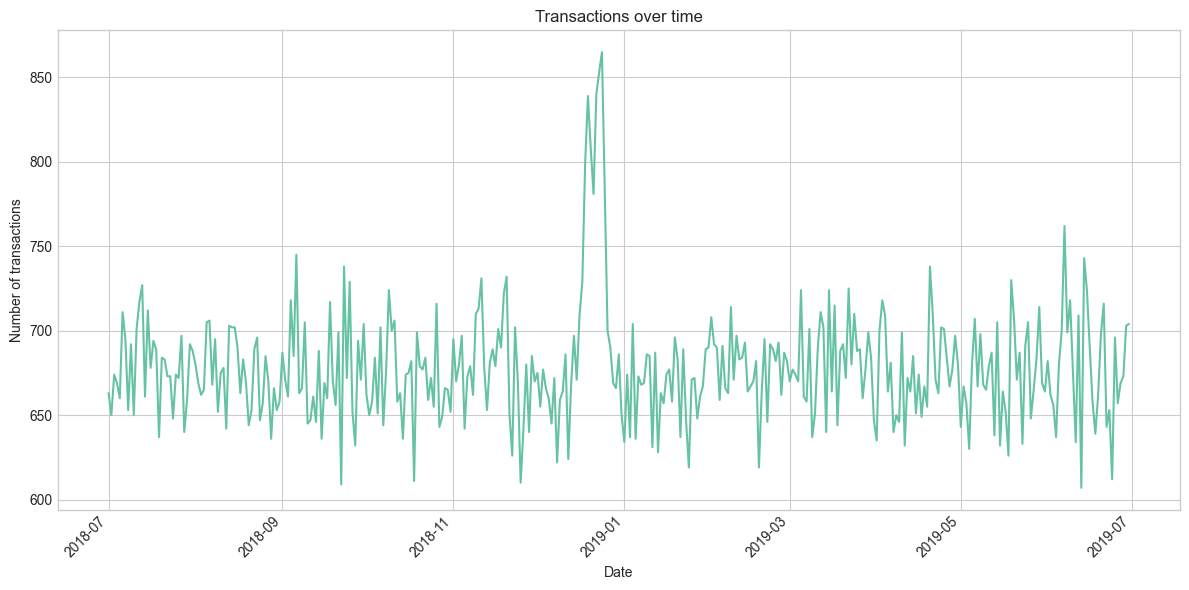

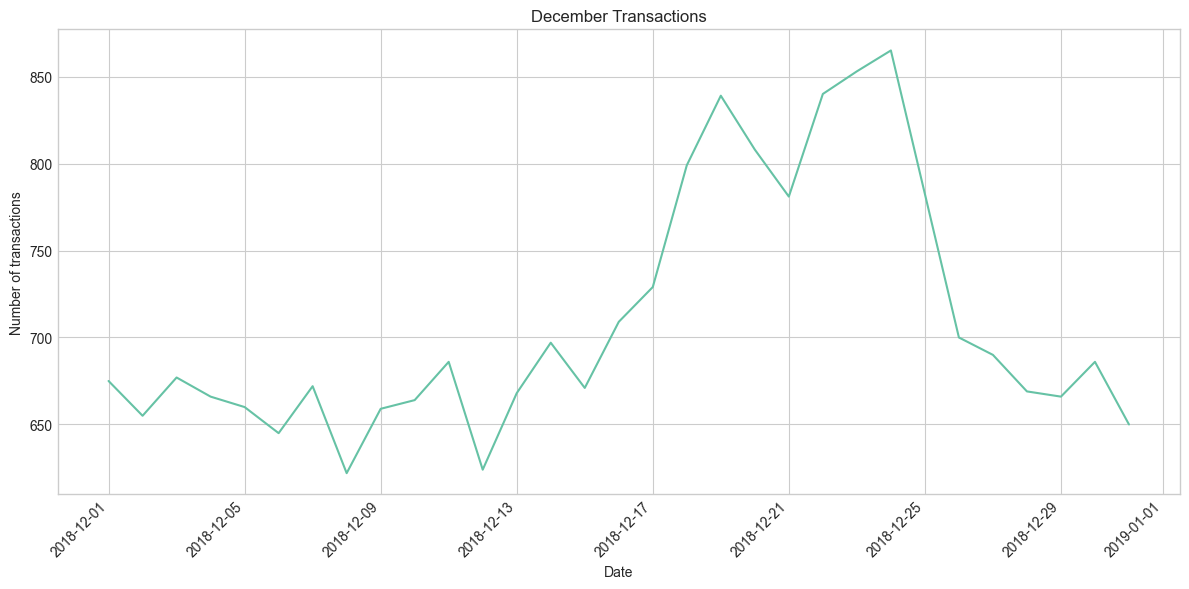

Date analysis complete.


In [14]:
if 'transaction_data_cleaned' in locals() and transaction_data_cleaned is not None:
    analyze_dates(transaction_data_cleaned)

### 3.5. Phân Tích Kích Thước Gói Sản Phẩm


Analyzing pack sizes...

Pack size distribution:
PACK_SIZE
70.0      1507
90.0      3008
110.0    22387
125.0     1454
134.0    25102
135.0     3257
150.0    38705
160.0     2970
165.0    15297
170.0    19983
175.0    64929
180.0     1468
190.0     2995
200.0     4473
210.0     3167
220.0     1564
250.0     3169
270.0     6285
330.0    12540
380.0     6416
Name: count, dtype: int64


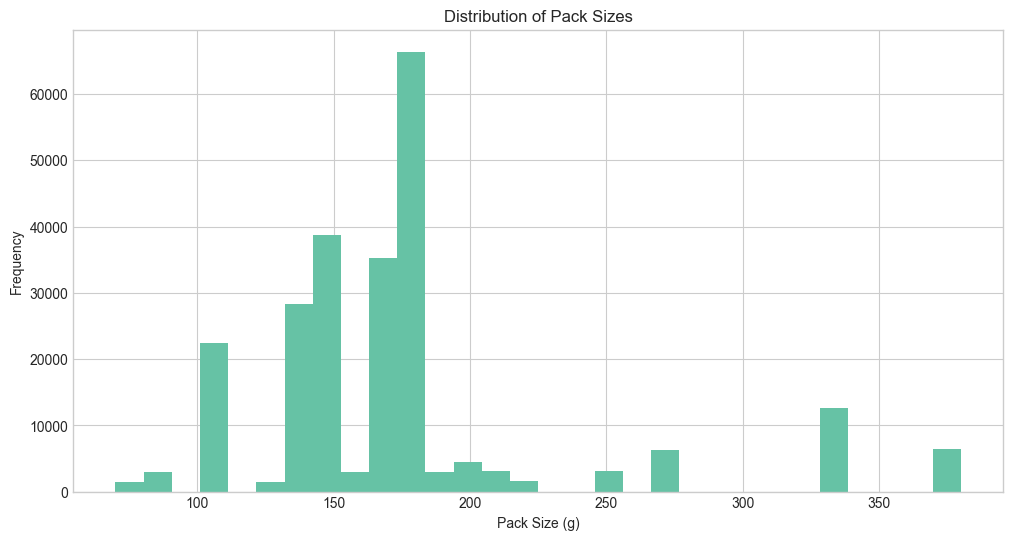

Pack size analysis complete.


In [15]:
if 'transaction_data_cleaned' in locals() and transaction_data_cleaned is not None:
    transaction_data_analyzed_pack = analyze_pack_sizes(transaction_data_cleaned.copy())

### 3.6. Phân Tích Thương Hiệu

In [16]:
if 'transaction_data_analyzed_pack' in locals() and transaction_data_analyzed_pack is not None:
    transaction_data_analyzed_brands = analyze_brands(transaction_data_analyzed_pack.copy())


Analyzing brands...

Brand distribution:
BRAND
KETTLE           41288
SMITHS           30353
DORITOS          25224
PRINGLES         25102
INFUZIONS        14201
THINS            14075
RED_ROCK_DELI    11894
WOOLWORTHS       11836
COBS              9693
TOSTITOS          9471
TWISTIES          9454
NATURAL           7469
TYRRELLS          6442
GRAINWAVES        6272
CHEEZELS          4603
CCS               4551
RED               4427
SUNBITES          3008
CHEETOS           2927
BURGER            1564
GRNWVES           1468
FRENCH            1418
Name: count, dtype: int64
Brand analysis complete.


### 3.7. Gộp Dữ Liệu Giao Dịch và Hành Vi Mua Hàng

In [17]:
data_merged = None
if ('transaction_data_analyzed_brands' in locals() and transaction_data_analyzed_brands is not None and 
    purchase_behavior is not None):
    
    if 'LYLTY_CARD_NBR' not in transaction_data_analyzed_brands.columns or \
       'LYLTY_CARD_NBR' not in purchase_behavior.columns:
        print("LYLTY_CARD_NBR column missing in one or both dataframes. Cannot merge.")
    else:
        data_merged = pd.merge(transaction_data_analyzed_brands, purchase_behavior, on='LYLTY_CARD_NBR', how='left')
        print("\nData merged successfully.")
        print(f"Shape of merged data: {data_merged.shape}")
        print(data_merged.head())
else:
    print("Skipping merge due to missing prerequisite data.")

if data_merged is not None and data_merged.empty:
    print("Merged data is empty. Stopping further analysis.")


Data merged successfully.
Shape of merged data: (246740, 12)
        DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 2018-10-17          1            1000       1         5   
1 2019-05-14          1            1307     348        66   
2 2019-05-20          1            1343     383        61   
3 2018-08-17          2            2373     974        69   
4 2018-08-18          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0    Natural Chip        Compny SeaSalt175g         2        6.0      175.0   
1                  CCs Nacho Cheese    175g         3        6.3      175.0   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9      170.0   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0      175.0   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8      150.0   

     BRAND               LIFESTAGE PREMIUM_CUSTOMER  
0  NATURAL   YOUNG SINGLES/COUPLES        

### 3.8. Phân Tích Phân Khúc Khách Hàng


Analyzing customer segments...


<Figure size 1200x600 with 0 Axes>

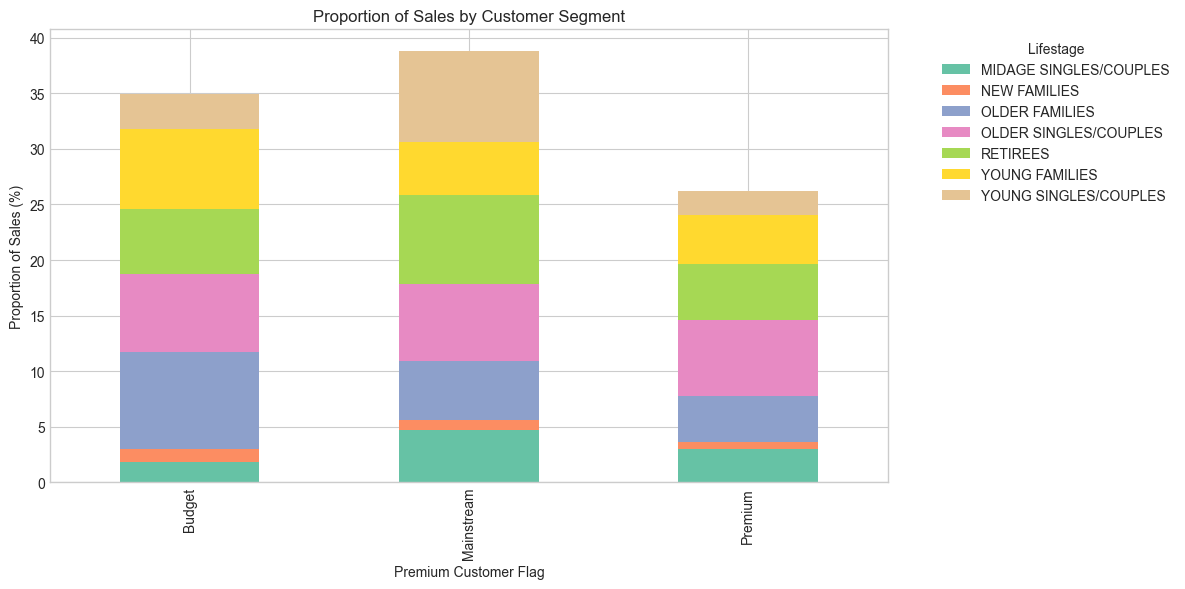


Customer counts by segment:
LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              1474
                        Mainstream          3298
                        Premium             2369
NEW FAMILIES            Budget              1087
                        Mainstream           830
                        Premium              575
OLDER FAMILIES          Budget              4611
                        Mainstream          2788
                        Premium             2231
OLDER SINGLES/COUPLES   Budget              4849
                        Mainstream          4858
                        Premium             4682
RETIREES                Budget              4385
                        Mainstream          6358
                        Premium             3812
YOUNG FAMILIES          Budget              3953
                        Mainstream          2685
                        Premium             2398
YOUNG SINGLES/COUPLES   Budget              3647

In [18]:
if data_merged is not None and not data_merged.empty:
    analyze_customer_segments(data_merged)

### 3.9. Phân Tích Hành Vi Mua Hàng


Analyzing purchase behavior...

Average units (based on overall unique customers):
                                         AVG_UNITS_PER_CUSTOMER_OVERALL
LIFESTAGE              PREMIUM_CUSTOMER                                
MIDAGE SINGLES/COUPLES Budget                                      0.12
                       Mainstream                                  0.30
                       Premium                                     0.20
NEW FAMILIES           Budget                                      0.07
                       Mainstream                                  0.06
                       Premium                                     0.04
OLDER FAMILIES         Budget                                      0.59
                       Mainstream                                  0.36
                       Premium                                     0.28
OLDER SINGLES/COUPLES  Budget                                      0.46
                       Mainstream                   

<Figure size 1200x600 with 0 Axes>

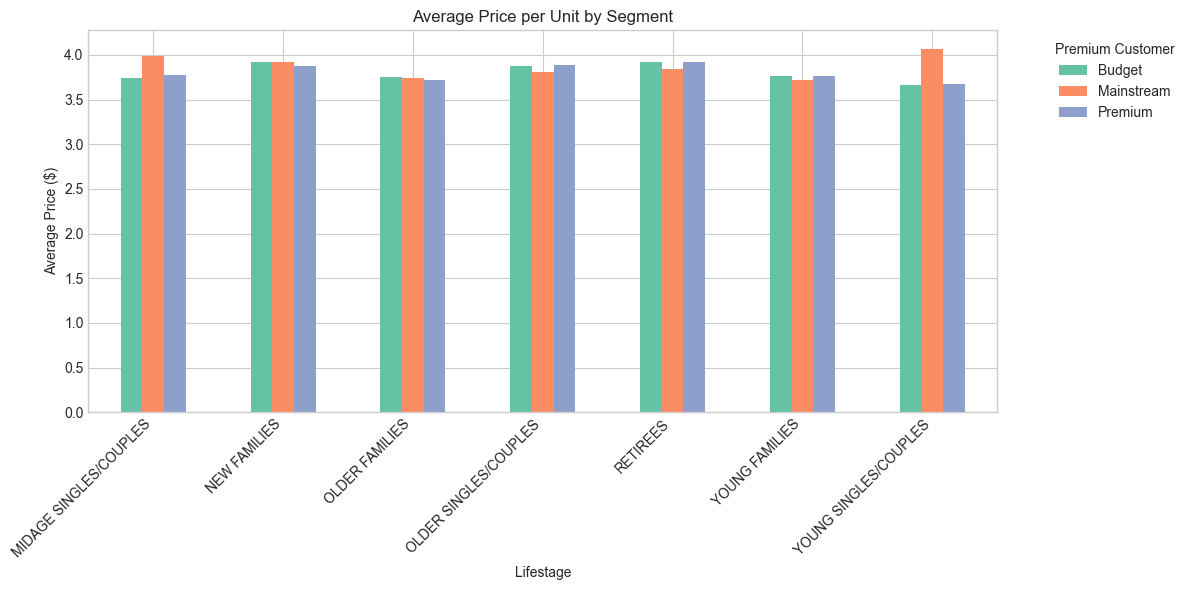

Purchase behavior analysis complete.


In [19]:
if data_merged is not None and not data_merged.empty:
    analyze_purchase_behavior(data_merged)

### 3.10. Phân Tích Mức Độ Ưa Thích Thương Hiệu


Analyzing brand affinity for YOUNG SINGLES/COUPLES...

Brand affinity scores (>1 means YOUNG SINGLES/COUPLES more likely to purchase):
TYRRELLS         1.09
TWISTIES         1.08
PRINGLES         1.08
GRAINWAVES       1.07
DORITOS          1.06
TOSTITOS         1.06
COBS             1.05
KETTLE           1.04
INFUZIONS        1.03
THINS            1.01
FRENCH           0.99
CHEEZELS         0.96
CCS              0.94
SMITHS           0.92
CHEETOS          0.89
RED_ROCK_DELI    0.89
NATURAL          0.89
WOOLWORTHS       0.87
SUNBITES         0.85
RED              0.85
dtype: float64


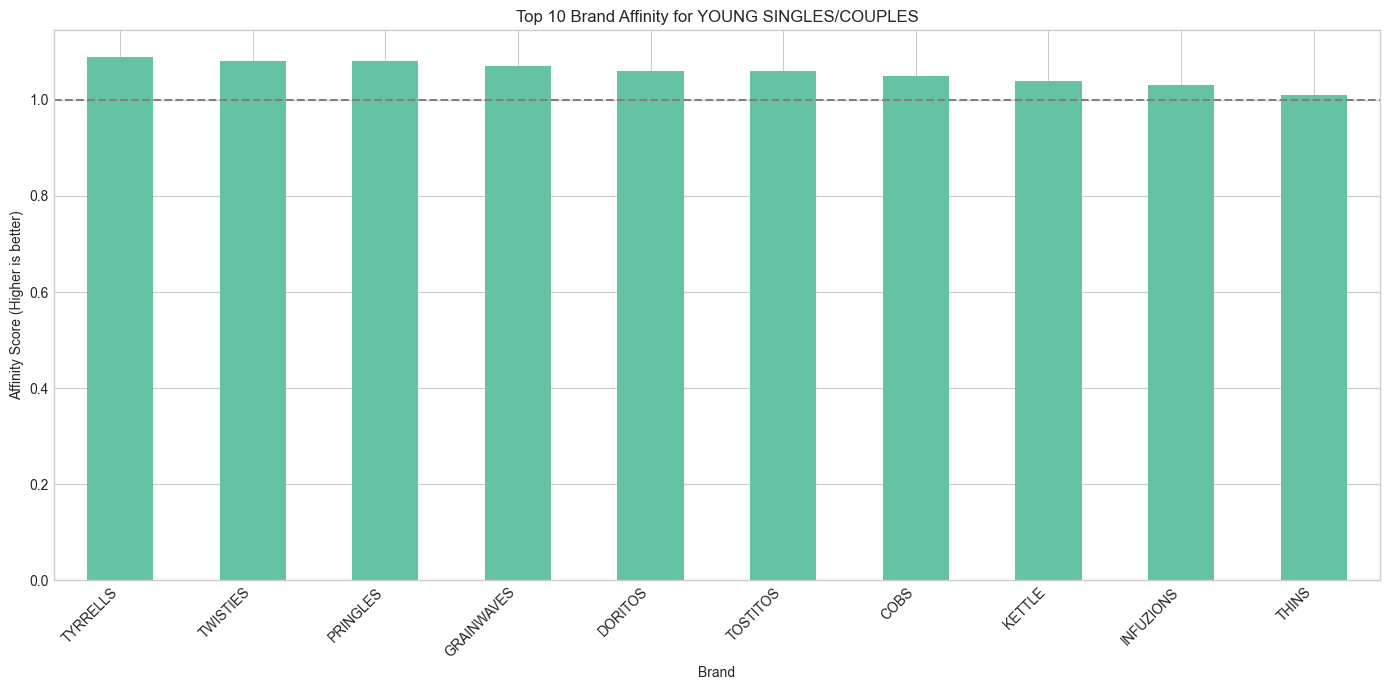

Brand affinity analysis complete.

Analyzing brand affinity for RETIREES...

Brand affinity scores (>1 means RETIREES more likely to purchase):
TWISTIES         1.08
KETTLE           1.07
THINS            1.07
DORITOS          1.06
PRINGLES         1.06
TYRRELLS         1.05
TOSTITOS         1.05
COBS             1.04
GRAINWAVES       1.04
INFUZIONS        1.02
CHEEZELS         1.00
SUNBITES         0.93
SMITHS           0.93
RED              0.91
NATURAL          0.90
GRNWVES          0.89
CHEETOS          0.87
WOOLWORTHS       0.85
BURGER           0.84
RED_ROCK_DELI    0.84
dtype: float64


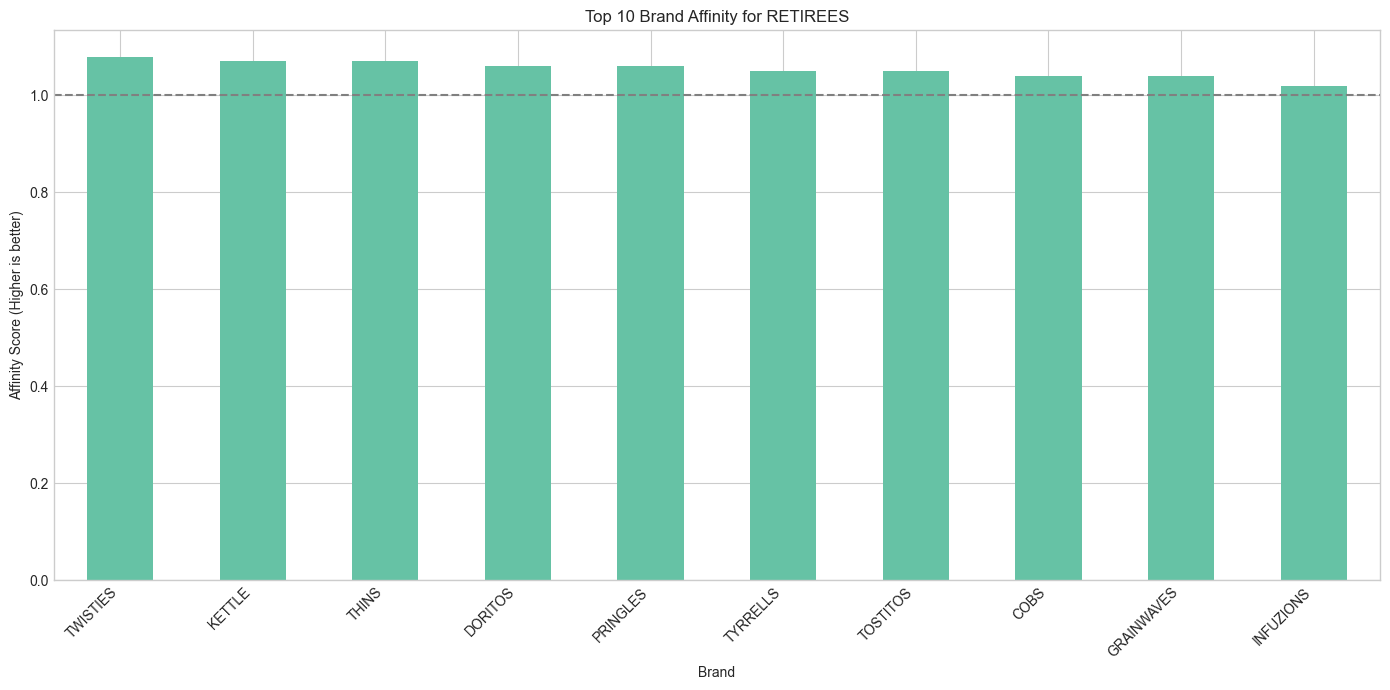

Brand affinity analysis complete.


In [20]:
if data_merged is not None and not data_merged.empty and 'LIFESTAGE' in data_merged.columns:
    target_segment_young = 'YOUNG SINGLES/COUPLES'
    if target_segment_young in data_merged['LIFESTAGE'].unique():
        analyze_brand_affinity(data_merged, target_segment_young)
    else:
        print(f"\nTarget segment '{target_segment_young}' not found in LIFESTAGE. Available segments:")
        print(data_merged['LIFESTAGE'].unique())
    
    target_segment_retirees = 'RETIREES'
    if target_segment_retirees in data_merged['LIFESTAGE'].unique():
         analyze_brand_affinity(data_merged, target_segment_retirees)
    else:
        print(f"\nTarget segment '{target_segment_retirees}' not found in LIFESTAGE.")

## 4. Lưu Kết Quả

In [21]:
if data_merged is not None and not data_merged.empty:
    try:
        data_merged.to_csv('processed_data_qvi.csv', index=False)
        print("\nAnalysis complete! Processed data saved to 'processed_data_qvi.csv'")
    except Exception as e:
        print(f"Error saving processed data: {e}")
else:
    print("\nNo processed data to save.")


Analysis complete! Processed data saved to 'processed_data_qvi.csv'


--- Kết thúc phân tích here---